<h1>Experiment with beer3pos</h1>

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import sys
basedir = '/home/joewandy/git/metabolomics_tools'
sys.path.append(basedir)

In [12]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

import cPickle
import random
import copy
import glob
import gzip

In [13]:
from alignment.models import HyperPars as AlignmentHyperPars
from alignment.experiment import *

<h2>Experiment Parameters</h2>

Set up all the experiment parameters

In [14]:
input_dir = '/home/joewandy/git/metabolomics_tools/alignment/input/beer3pos'
transformation_file = '/home/joewandy/git/metabolomics_tools/alignment/pos_transformations_full.yml'
gt_file = '/home/joewandy/git/metabolomics_tools/alignment/input/beer3pos/ground_truth/beer3.positive.dat'

In [15]:
hp = AlignmentHyperPars()    
hp.within_file_mass_tol = 3
hp.within_file_rt_tol = 10
hp.across_file_mass_tol = 10
hp.across_file_rt_tol = 60
hp.alpha_mass = 1
hp.dp_alpha = 1000.0
hp.beta = 0.1
hp.t = 0.0
hp.mass_clustering_n_iterations = 10000
hp.rt_clustering_nsamps = 1000
hp.rt_clustering_burnin = 0

print hp

Hyperparameters across_file_mass_tol=10, across_file_rt_tol=60, alpha_mass=1, beta=0.1, dp_alpha=1000.0, mass_clustering_n_iterations=10000, matching_alpha=0.3, rt_clustering_burnin=0, rt_clustering_nsamps=1000, second_stage_clustering_use_adduct_likelihood=True, second_stage_clustering_use_mass_likelihood=True, second_stage_clustering_use_rt_likelihood=True, t=0.0, within_file_mass_tol=3, within_file_rt_tol=10


In [16]:
evaluation_method = 2
n_iter = 1

In [17]:
param_list = []
for mass_tol in range(2, 7, 2):
    for rt_tol in range(5, 31, 5):
        param_list.append((mass_tol, rt_tol))

In [18]:
param_list_mwg = []
for mass_tol in range(2, 7, 2):
    for rt_tol in range(5, 31, 5):
        for group_tol in range(2, 11, 2):
            for alpha in range(0, 11, 2):
                param_list_mwg.append((mass_tol, rt_tol, group_tol, alpha/10.0))

<h2>Create the first-stage clustering for all input files -- Gibbs, mh_biggest=True</h2>

In [19]:
combined_list = load_or_create_clustering('pickles/beer3pos/clustering.p', input_dir, transformation_file, hp)

Loaded from pickles/beer3pos/clustering.p


<h2>Run experiment with beer3pos</h2>

In [20]:
n_files = 3

In [21]:
training_list = load_or_create_filelist('pickles/beer3pos/training_list.p', combined_list, n_iter, n_files)

Loaded from pickles/beer3pos/training_list.p
['beer3-file1.csv', 'beer3-file2.csv', 'beer3-file3.csv']


In [22]:
testing_list = load_or_create_filelist('pickles/beer3pos/testing_list.p', combined_list, n_iter, n_files)

Loaded from pickles/beer3pos/testing_list.p
['beer3-file3.csv', 'beer3-file2.csv', 'beer3-file1.csv']


In [23]:
exp_results_1a = run_experiment(0, training_list, testing_list, param_list, 'pickles/beer3pos/res_match_feature.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer3pos/res_match_feature.p


In [24]:
exp_results_1b = run_experiment(1, training_list, testing_list, param_list, 'pickles/beer3pos/res_match_cluster.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer3pos/res_match_cluster.p


In [25]:
exp_results_1c = run_experiment(3, training_list, testing_list, param_list_mwg, 'pickles/beer3pos/res_mwg.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer3pos/res_mwg.p


In [26]:
# cluster_cluster = second_stage_clustering(hp, training_list, 0, evaluation_method, transformation_file, gt_file, use_adduct_likelihood=True)

In [27]:
# cluster_cluster.to_pickle('pickles/beer3pos/cluster_cluster.p')

In [28]:
cluster_cluster = pd.read_pickle('pickles/beer3pos/cluster_cluster.p')

In [29]:
# cluster_cluster_no_adduct = second_stage_clustering(hp, training_list, 0, evaluation_method, transformation_file, gt_file, use_adduct_likelihood=False)

In [32]:
# cluster_cluster_no_adduct.to_pickle('pickles/beer3pos/cluster_cluster_no_adduct.p')

In [31]:
cluster_cluster_no_adduct = pd.read_pickle('pickles/beer3pos/cluster_cluster_no_adduct.p')

<h2>Plotting</h2>

In [46]:
sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

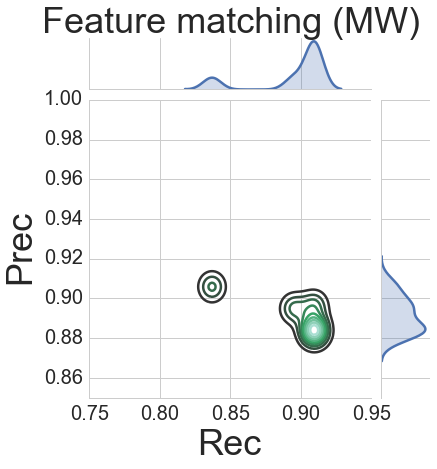

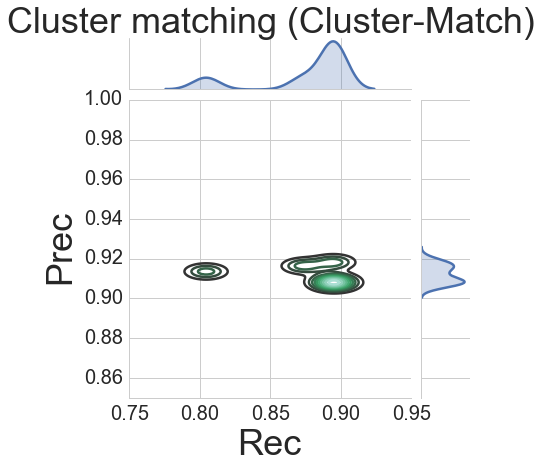

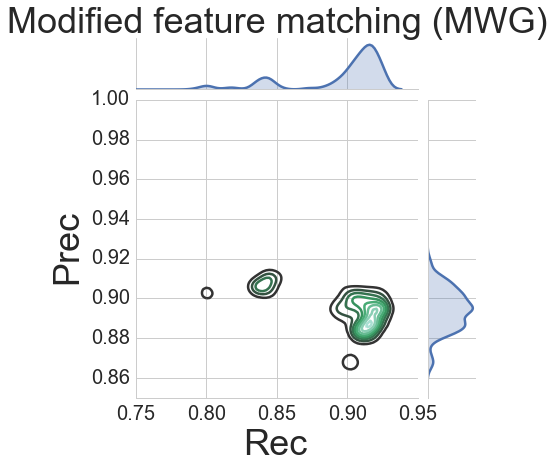

In [47]:
plot_density(exp_results_1a, 'Feature matching (MW)', xlim=(0.75, 0.95), ylim=(0.85, 1.0))
plot_density(exp_results_1b, 'Cluster matching (Cluster-Match)', xlim=(0.75, 0.95), ylim=(0.85, 1.0))
plot_density(exp_results_1c, 'Modified feature matching (MWG)', xlim=(0.75, 0.95), ylim=(0.85, 1.0))

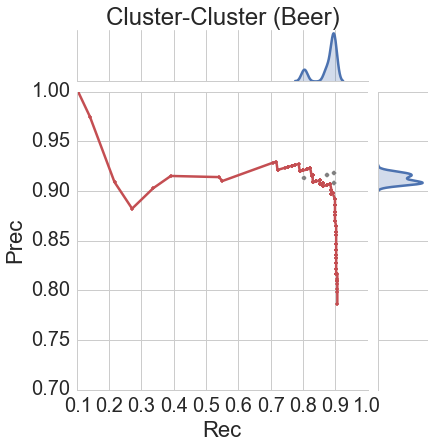

In [48]:
plot_scatter(exp_results_1b, 0, cluster_cluster, 'Cluster-Cluster (Beer)')

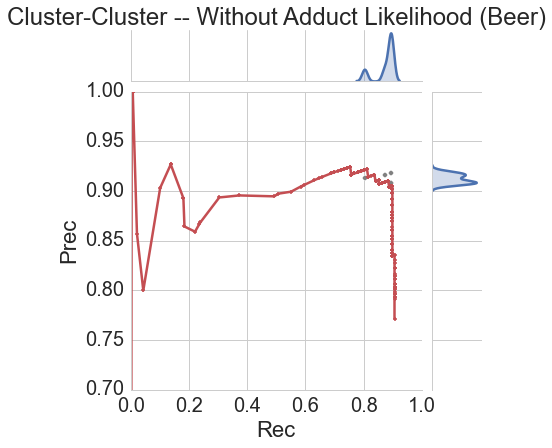

In [49]:
plot_scatter(exp_results_1b, 0, cluster_cluster_no_adduct, 'Cluster-Cluster -- Without Adduct Likelihood (Beer)')